### probability distributions - european roulette

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#### create Roulette

In [2]:
from roulette import Roulette

In [96]:
r = Roulette(fake_factor = 0.1225)
df = r.sample(n = 1000)

In [97]:
df

,number,f1,f2,f3
0,29,pass,odd,black
1,7,fail,odd,red
2,1,fail,odd,red
3,36,pass,even,red
4,26,pass,even,black
...,...,...,...,...
995,14,fail,even,red
996,22,pass,even,black
997,24,pass,even,black
998,9,fail,odd,red


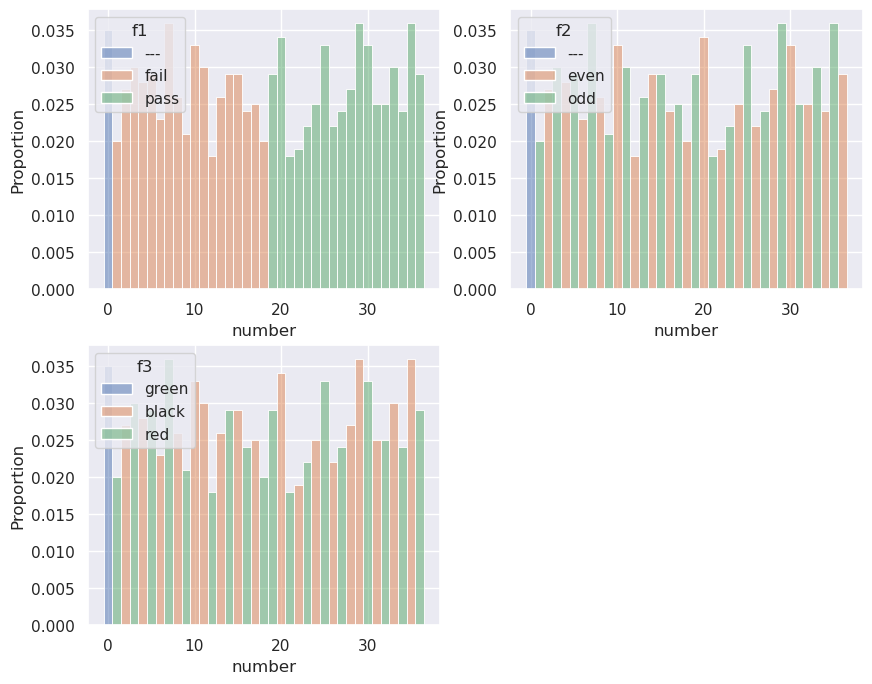

In [57]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
sns.histplot(ax = axs[0, 0], data = df, x = 'number', hue = 'f1', discrete = True, stat = 'proportion')
sns.histplot(ax = axs[0, 1], data = df, x = 'number', hue = 'f2', discrete = True, stat = 'proportion')
sns.histplot(ax = axs[1, 0], data = df, x = 'number', hue = 'f3', discrete = True, stat = 'proportion')
axs[1, 1].axis('off');

### strategy 1. 

- Estimate univariate distribution of variable 'number' and bet to most likely number

In [38]:
# histogram
hist = np.zeros(37)
for x in df.number: hist[x] += 1
np.argmax(hist), hist.argsort()

(26,
 array([11, 30,  3,  6, 23,  9,  8, 18, 17, 36, 19, 35,  1, 32, 21, 33,  7,
        31,  5,  2, 15, 34, 29, 27, 14, 16, 13, 10, 25, 12,  0,  4, 22, 20,
        24, 28, 26]))

In [54]:
# game simulation
fitxes = 500
jugades = 0
while fitxes > 0 and jugades < 100000:
    jugades +=1
    fitxes -=4
    # simulem la tirada de la ruleta (inverse sampling)
#    if r.draw() == np.argmax(hist):
    if r.draw() in hist.argsort()[-4:]:
        fitxes += 37
print('+++ jugades %4d, fitxes %4d' %(jugades, fitxes))

+++ jugades 100000, fitxes 26555


##### how likely is this strategy to be winner?

- estimate the cdf of the numbers
- get a sample by inverse sampling
- get a new saple from the roulette
- if the two samples look similar:
    - we can trust de distribution we have seen
    - we can be confident about the likelihood of the number with maximum frequency

In [ ]:
bins = np.arange(37)
# density (pdf)
pdf = hist /np.sum(hist) /1.0
# cumulative (cdf), bin_width is 1.0
cdf = np.cumsum(pdf *1.0)
cdf

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
# check pdf
sns.histplot(ax = axs[0], data = df, x = 'number', hue = 'f3', discrete = True, stat = 'density')
sns.lineplot(ax = axs[0], x = bins, y = pdf, color = sns.color_palette()[1])
# check cdf
sns.ecdfplot(ax = axs[1], data = df, x = 'number')
sns.lineplot(ax = axs[1], x = bins, y = cdf);

In [ ]:
# get sample from the cdf by inverse sampling
cdf_sample = [np.where(cdf > x)[0][0] for x in np.random.rand(1000)]

In [ ]:
# new sample from the roulette
roulette_sample = [r.draw() for x in range(1000)]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
sns.histplot(ax = axs[0], data = roulette_sample, binwidth = 1, discrete = True, stat = 'density');
sns.histplot(ax = axs[1], data = cdf_sample, binwidth = 1, discrete = True, stat = 'density');
plt.tight_layout()

### Strategy 2
- Estimate multivariate distribution of f1, f2 and f3
- f1, f2 and f3 all have cardinality 2
- the multivariate distribution has cardinality $\; 2 *2 *2 = 2^3 = 8$

In [98]:
# contingency table
df.groupby(['f1', 'f2', 'f3']).count()

number
f1   f2   f3           
---  ---  green      27
fail even black     120
          red       107
     odd  black     104
          red       119
pass even black     162
          red       133
     odd  black      98
          red       130

In [99]:
hist = df.groupby(['f1', 'f2', 'f3']).count().reset_index().number
np.argmax(hist)

5

In [88]:
hist

0     35
1    137
2     91
3    110
4    136
5    127
6    111
7    127
8    126
Name: number, dtype: int64

<Axes: ylabel='number'>

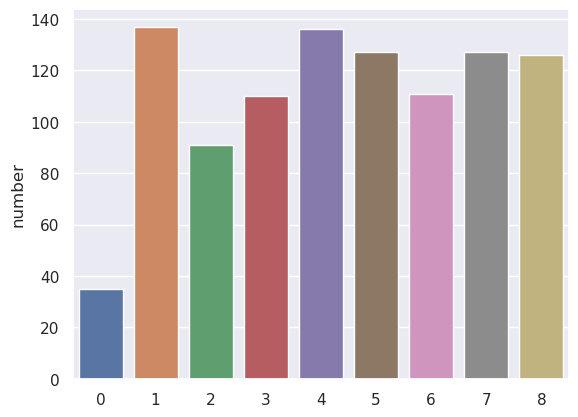

In [89]:
sns.barplot(x = hist.index, y = hist)

In [113]:
# game simulation
fitxes = 100
jugades = 0
while fitxes > 2 and jugades < 1000:
    # bet for pass, even, black (joint index 5)
    fitxes -=3
    jugades +=1
    number = r.draw()
    if number != 0:
        if number > 18: fitxes += 2
        if r.even(number): fitxes += 2
        if r.black(number): fitxes += 2
print('+++ jugades %4d, fitxes %4d' %(jugades, fitxes))

+++ jugades 1000, fitxes   82


In [114]:
df.loc[(df.f1 == 'pass') &(df.f2 == 'even') &(df.f3 == 'black')].number.unique()

array([26, 24, 28, 22, 20])

In [164]:
# game simulation
fitxes = 100
jugades = 0
while fitxes > 3 and jugades < 1000:
    # bet for 20, 22, 24
    fitxes -=4
    jugades +=1
    number = r.draw()
    if number in [20, 22, 24, 26]:
        fitxes += 37
print('+++ jugades %4d, fitxes %4d' %(jugades, fitxes))

+++ jugades 1000, fitxes  503


#### plot the joint distribution of f1, f2, f3